Import all librarys

In [121]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.layers import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
import scipy
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.utils import load_img, img_to_array
from keras.models import load_model
from keras.optimizers import Adam

Test if tensorflow is using the GPU of our system

In [77]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS NOT** using the GPU


# Load the data of the directory

In [78]:
data_dir = "./data/Train/"

In [79]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256,256),
  batch_size=32)

Found 934 files belonging to 5 classes.
Using 748 files for training.


In [80]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256,256),
  batch_size=32)

Found 934 files belonging to 5 classes.
Using 186 files for validation.


In [81]:
class_names = train_ds.class_names
print(class_names)

['Bathroom', 'Bedroom', 'House Map', 'Kitchen', 'Living Room']


Show a sample of the 9 first images

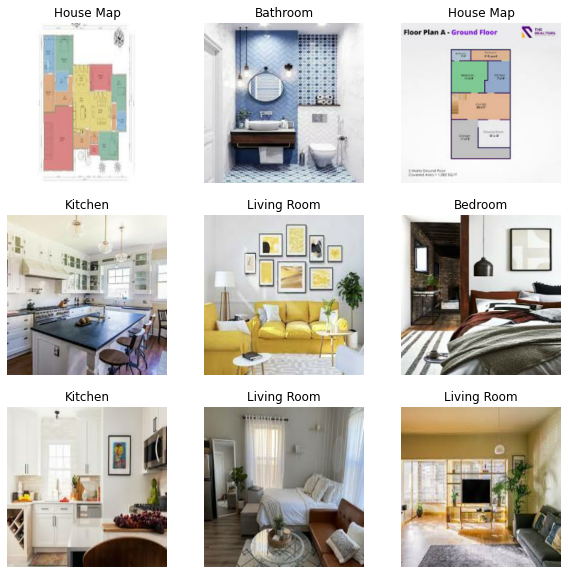

In [82]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [83]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


# Preprocess data

Scale the image dividing it by 255

In [84]:
normalization_layer = Rescaling(1./255)

In [85]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
normalized_valid_ds = val_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 1.0


# Train the models

Model trained using convultional neural network

In [86]:
numberOfClass = len(class_names)
def def_conv_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32,(3,3),input_shape = input_shape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(32,(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Conv2D(64,(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(numberOfClass)) # output
    model.add(Activation("softmax"))
    return model

In [87]:
conv_model = def_conv_model(input_shape=(256,256,3))

In [88]:
conv_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [89]:
conv_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 activation_40 (Activation)  (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 activation_41 (Activation)  (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                 

In [90]:
epochs=20
conv_hist = conv_model.fit(
  normalized_train_ds,
  validation_data= normalized_valid_ds,
  epochs=epochs
)

Epoch 1/20


c:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\env\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


24/24 [==============================] - 33s 1s/step - loss: 3.0273 - accuracy: 0.2660 - val_loss: 1.3767 - val_accuracy: 0.3280
Epoch 2/20
24/24 [==============================] - 31s 1s/step - loss: 1.3082 - accuracy: 0.4385 - val_loss: 1.2716 - val_accuracy: 0.5215
Epoch 3/20
24/24 [==============================] - 29s 1s/step - loss: 0.9887 - accuracy: 0.6217 - val_loss: 1.0475 - val_accuracy: 0.5860
Epoch 4/20
24/24 [==============================] - 29s 1s/step - loss: 0.6872 - accuracy: 0.7460 - val_loss: 1.2747 - val_accuracy: 0.5430
Epoch 5/20
24/24 [==============================] - 29s 1s/step - loss: 0.4653 - accuracy: 0.8302 - val_loss: 1.2526 - val_accuracy: 0.5753
Epoch 6/20
24/24 [==============================] - 29s 1s/step - loss: 0.3262 - accuracy: 0.8904 - val_loss: 1.2165 - val_accuracy: 0.5591
Epoch 7/20
24/24 [==============================] - 29s 1s/step - loss: 0.1601 - accuracy: 0.9545 - val_loss: 1.5923 - val_accuracy: 0.5914
Epoch 8/20
24/24 [=============

In [91]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

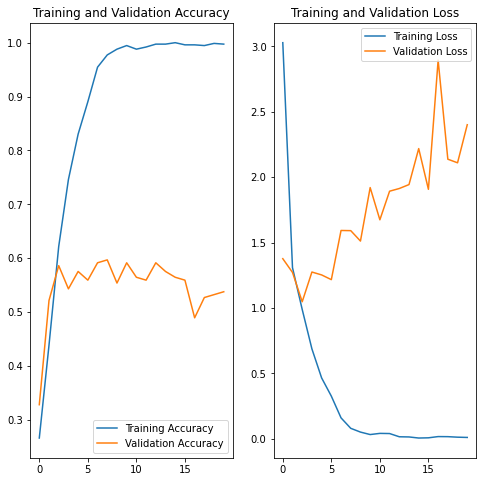

In [92]:
plot_history(conv_hist)

Model with convolutional neural network using image data generator

In [93]:
width_shape = 224
height_shape = 224
num_classes = 5
epochs = 50
batch_size = 32 

In [150]:

train_datagen = ImageDataGenerator( 
    rescale= 1./255,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    validation_split= 0.2)

valid_datagen = ImageDataGenerator(rescale= 1./255, validation_split= 0.2)

train_generator = train_datagen.flow_from_directory(data_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    subset= "training",
    batch_size= batch_size)

valid_generator = valid_datagen.flow_from_directory(data_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    subset= "validation",
    batch_size= batch_size)


Found 748 images belonging to 5 classes.
Found 186 images belonging to 5 classes.


In [126]:
print(train_generator.next()[0][1])

[[[0.8000001  0.7725491  0.73333335]
  [0.8000001  0.7725491  0.73333335]
  [0.8000001  0.7725491  0.73333335]
  ...
  [0.7451262  0.7412046  0.72276485]
  [0.7119624  0.70804083 0.69955015]
  [0.7315078  0.73688775 0.7259441 ]]

 [[0.8007908  0.7733398  0.7341241 ]
  [0.8000001  0.7725491  0.73333335]
  [0.8000001  0.7725491  0.73333335]
  ...
  [0.7194595  0.7155379  0.7047981 ]
  [0.72625977 0.7293907  0.71919674]
  [0.7337637  0.74160683 0.73333335]]

 [[0.80392164 0.77647066 0.7372549 ]
  [0.8023484  0.7748974  0.7356817 ]
  [0.800109   0.77265805 0.73344237]
  ...
  [0.7210118  0.7218936  0.7124493 ]
  [0.7352631  0.74310625 0.73333335]
  [0.7294118  0.73803645 0.73489636]]

 ...

 [[0.6762828  0.6449102  0.60177296]
  [0.67996067 0.6485881  0.6054508 ]
  [0.6908338  0.65946126 0.616324  ]
  ...
  [0.3965913  0.37698346 0.30247363]
  [0.38730738 0.36769953 0.29318973]
  [0.3860087  0.36640087 0.29189104]]

 [[0.6784612  0.64708865 0.6039514 ]
  [0.687835   0.65646243 0.6133251 ]


Plot examples of the images

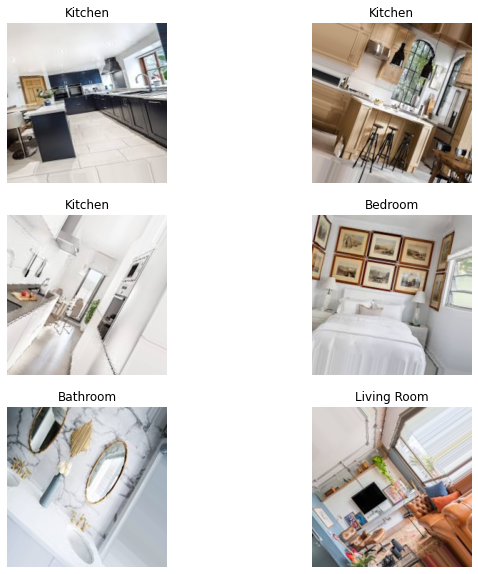

In [96]:
batch =  train_generator.next()
  
plt.figure(figsize=(10, 10))

for i in range(6):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(batch[0][i])
  plt.title(class_names[np.argmax(batch[1][i])])
  plt.axis("off")

In [97]:
model_conv_with_data_gen = def_conv_model(input_shape=(224,224,3))

In [98]:
model_conv_with_data_gen.compile(optimizer = 'adam', loss = categorical_crossentropy, metrics = ['accuracy'] )

conv_hist_with_data_generator = model_conv_with_data_gen.fit(train_generator,
                           epochs = epochs,
                           validation_data= valid_generator
                           )

Epoch 1/50
24/24 [==============================] - 23s 922ms/step - loss: 2.0908 - accuracy: 0.2326 - val_loss: 1.5611 - val_accuracy: 0.2634
Epoch 2/50
24/24 [==============================] - 22s 895ms/step - loss: 1.5533 - accuracy: 0.2620 - val_loss: 1.4832 - val_accuracy: 0.3226
Epoch 3/50
24/24 [==============================] - 22s 893ms/step - loss: 1.4586 - accuracy: 0.3235 - val_loss: 1.3732 - val_accuracy: 0.3333
Epoch 4/50
24/24 [==============================] - 21s 871ms/step - loss: 1.4433 - accuracy: 0.3449 - val_loss: 1.3382 - val_accuracy: 0.3656
Epoch 5/50
24/24 [==============================] - 21s 866ms/step - loss: 1.3415 - accuracy: 0.3690 - val_loss: 1.2934 - val_accuracy: 0.3871
Epoch 6/50
24/24 [==============================] - 21s 868ms/step - loss: 1.3284 - accuracy: 0.3810 - val_loss: 1.2107 - val_accuracy: 0.4946
Epoch 7/50
24/24 [==============================] - 21s 865ms/step - loss: 1.3181 - accuracy: 0.4225 - val_loss: 1.2918 - val_accuracy: 0.4301

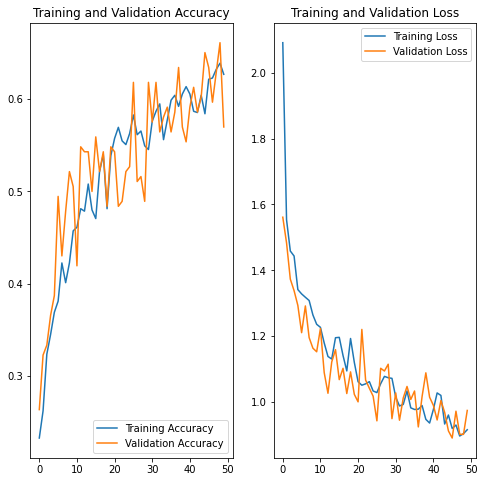

In [99]:
plot_history(conv_hist_with_data_generator)

Model using transfer learning techniche with MobileNetV2 layers

In [100]:
numberOfClass = len(class_names)

In [101]:
base_model=MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
x = Dropout(0.5)(x)
preds=Dense(numberOfClass,activation='softmax')(x) #final layer with softmax activation

In [102]:
transfer_learning_model=Model(inputs=base_model.input,outputs=preds)

In [103]:
for i,layer in enumerate(transfer_learning_model.layers):
  print(i,layer.name)

0 input_3
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [104]:
for layer in transfer_learning_model.layers[:-6]:
    layer.trainable=False

In [105]:
transfer_learning_model.compile(optimizer = 'adam', loss = categorical_crossentropy, metrics = ['accuracy'] )

transfer_learning_hist = transfer_learning_model.fit_generator(train_generator,
                           epochs = epochs,
                           validation_data= valid_generator
                           )

C:\Users\danie\AppData\Local\Temp\ipykernel_8368\689159174.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_hist = transfer_learning_model.fit_generator(train_generator,


Epoch 1/50
24/24 [==============================] - 19s 705ms/step - loss: 1.3101 - accuracy: 0.4826 - val_loss: 0.6818 - val_accuracy: 0.7527
Epoch 2/50
24/24 [==============================] - 16s 661ms/step - loss: 0.6660 - accuracy: 0.7500 - val_loss: 0.3147 - val_accuracy: 0.9086
Epoch 3/50
24/24 [==============================] - 16s 668ms/step - loss: 0.6539 - accuracy: 0.7447 - val_loss: 0.3639 - val_accuracy: 0.8495
Epoch 4/50
24/24 [==============================] - 16s 669ms/step - loss: 0.5479 - accuracy: 0.7781 - val_loss: 0.3759 - val_accuracy: 0.8441
Epoch 5/50
24/24 [==============================] - 16s 660ms/step - loss: 0.4256 - accuracy: 0.8302 - val_loss: 0.2696 - val_accuracy: 0.9032
Epoch 6/50
24/24 [==============================] - 16s 657ms/step - loss: 0.4409 - accuracy: 0.8235 - val_loss: 0.3041 - val_accuracy: 0.8871
Epoch 7/50
24/24 [==============================] - 16s 649ms/step - loss: 0.3539 - accuracy: 0.8636 - val_loss: 0.4616 - val_accuracy: 0.8548

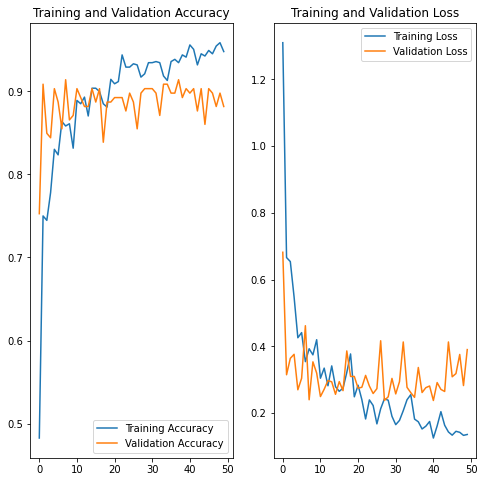

In [106]:
plot_history(transfer_learning_hist)

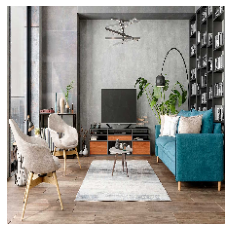

1/1 [==============================] - 1s 630ms/step
The prediction is Living Room


In [107]:
def load_image(img_path, show=False):


    img = load_img(img_path, target_size=(width_shape, height_shape))
    img_tensor =    img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.  
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor
  
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = r'C:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\data\Test\salon1.jpeg'
new_image = load_image(img_path,show=True)

pred = transfer_learning_model.predict(new_image)

print(f'The prediction is {class_names[np.argmax(pred)]}')


In [151]:
transfer_learning_model.save("./Models/model_transfer_learning/model_transfer_learning.h5",overwrite=True)

In [152]:
transfer_learning_model = load_model('Models\model_transfer_learning\model_transfer_learning.h5')

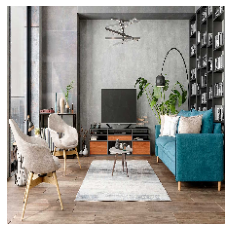

1/1 [==============================] - 1s 593ms/step


array([[3.9193814e-04, 4.2227149e-02, 3.7691669e-07, 5.3831653e-05,
        9.5732671e-01]], dtype=float32)

In [142]:
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = r'C:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\data\Test\salon1.jpeg'
new_image = load_image(img_path,show=True)

pred = transfer_learning_model.predict(new_image)

pred

Model unfreezing the first layers of the previous model and learning with a little learning rate

In [153]:
transfer_learning_modelv2 = tf.keras.models.clone_model(transfer_learning_model)

In [154]:
transfer_learning_modelv2.trainable = True

In [155]:
for layer in transfer_learning_modelv2.layers[-6:]:
    layer.trainable = False

In [156]:
transfer_learning_modelv2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

In [157]:
print(len(transfer_learning_modelv2.trainable_variables))
print(len(transfer_learning_modelv2.layers))

156
160


In [158]:
transfer_learning_modelv2.compile(optimizer = Adam(learning_rate=0.0005), loss = categorical_crossentropy, metrics = ['accuracy'] )
epochs = 10

transfer_learning_hist_v2 = transfer_learning_modelv2.fit_generator(train_generator,
                           epochs = epochs,
                           validation_data= valid_generator
                           )

C:\Users\danie\AppData\Local\Temp\ipykernel_8368\2437532168.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_hist_v2 = transfer_learning_modelv2.fit_generator(train_generator,


Epoch 1/10
24/24 [==============================] - 71s 3s/step - loss: 1.4898 - accuracy: 0.3195 - val_loss: 1.6088 - val_accuracy: 0.2204
Epoch 2/10
24/24 [==============================] - 65s 3s/step - loss: 1.3142 - accuracy: 0.4091 - val_loss: 1.6077 - val_accuracy: 0.2258
Epoch 3/10
24/24 [==============================] - 65s 3s/step - loss: 1.2733 - accuracy: 0.4211 - val_loss: 1.6066 - val_accuracy: 0.2258
Epoch 4/10
24/24 [==============================] - 64s 3s/step - loss: 1.2572 - accuracy: 0.4439 - val_loss: 1.6061 - val_accuracy: 0.2258
Epoch 5/10
24/24 [==============================] - 68s 3s/step - loss: 1.2158 - accuracy: 0.4799 - val_loss: 1.6055 - val_accuracy: 0.2258
Epoch 6/10
24/24 [==============================] - 69s 3s/step - loss: 1.1926 - accuracy: 0.4773 - val_loss: 1.6053 - val_accuracy: 0.2258
Epoch 7/10
24/24 [==============================] - 67s 3s/step - loss: 1.1490 - accuracy: 0.5160 - val_loss: 1.6058 - val_accuracy: 0.2258
Epoch 8/10
24/24 [==

In [ ]:
plot_history(transfer_learning_hist_v2)